Using a Random Forest Regressor now, getting a much better accuracy score

# Data Preprocessing
Handling Missing Data

pandas: dropna, fillna
Data Cleaning, formatting

Encoding categorical data

pandas: get_dummies
sklearn: LabelEncoder, OneHotEncoder
Splitting the data into Train and Test

sklearn: train_test_split
Feature Scaling:

Standardization: (x - mean(x)) / std(x) sklearn StandardScaler
Normalization: (x - min(x)) / (max(x) - min(x)) sklearn MinMaxScaler

1.IMPORTING LIBRARIES

In [3]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import re

import time
import datetime




2.LOADING FILE

In [4]:
# Loading the data
df = pd.read_csv('googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Note that some of the variables got missing values indicated by '0'. But this is not reliable and we need a summary statistics. Let's take a look at list of variables.

In [5]:
# Checking the data type of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


The dataset has 10,841 records and 13 columns, all of them are object types except the target column (Rating) which is float

App               False
Category          False
Rating             True
Reviews           False
Size              False
Installs          False
Type               True
Price             False
Content Rating     True
Genres            False
Last Updated      False
Current Ver        True
Android Ver        True
dtype: bool

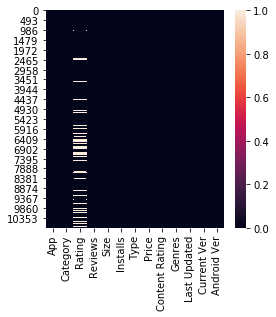

In [6]:
# Exploring missing data and checking if any has NaN values
plt.figure(figsize=(4,4))
sns.heatmap(df.isnull())
df.isnull().any()

Looks like there are missing values in "Rating", "Type", "Content Rating" and " Android Ver". But most of these missing values in Rating column.

In [7]:
df.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

There are two strategies to handle missing data, 
1.Removing records with these missing values 
2.replacing missing values with a specific value of the column.

3.DATA CLEANING

In [8]:
# The best way to fill missing values might be using the median instead of mean.
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

# Before filling null values we have to clean all non numerical values & unicode charachters 
replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
    df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
    df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)
df['Current Ver'] = df['Current Ver'].fillna(df['Current Ver'].median())

In [9]:
# Count the number of unique values in category column 
df['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '1.9'], dtype=object)

In [10]:
# Check the record  of unreasonable value which is 1.9
i = df[df['Category'] == '1.9'].index
df.loc[i]
df = df.drop(i)

It's obvious that the first value of this record is missing (App name) and all other values are respectively propagated backward starting from "Category" towards the "Current Ver"; and the last column which is "Android Ver" is left null. It's better to drop the entire recored instead of consider these unreasonable values while cleaning each column!


In [11]:
# Removing NaN values
df = df[pd.notnull(df['Last Updated'])]
df = df[pd.notnull(df['Content Rating'])]

# 4.Categorical Data Encoding¶

Many machine learning algorithms can support categorical values without further manipulation but there are many more algorithms that do not. We need to make all data ready for the model, so we will convert categorical variables (variables that stored as text values) into numircal variables.

In [12]:
# App values encoding
le = preprocessing.LabelEncoder()
df['App'] = le.fit_transform(df['App'])
# This encoder converts the values into numeric values

In [13]:
# Category features encoding
category_list = df['Category'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
df = pd.concat([df, pd.get_dummies(df['Category'], prefix='cat')], axis=1)

In [14]:
# Genres features encoding
le = preprocessing.LabelEncoder()
df['Genres'] = le.fit_transform(df['Genres'])

In [15]:
# Encode Content Rating features
le = preprocessing.LabelEncoder()
df['Content Rating'] = le.fit_transform(df['Content Rating'])

In [16]:
# Price cealning
df['Price'] = df['Price'].apply(lambda x : x.strip('$'))

In [17]:
# Installs cealning
df['Installs'] = df['Installs'].apply(lambda x : x.strip('+').replace(',', ''))

In [18]:
# Type encoding
df['Type'] = pd.get_dummies(df['Type'])

The above line drops the reference column and just keeps only one of the two columns as retaining this extra column does not add any new information for the modeling process, this line is exactly the same as setting drop_first parameter to True.

In [19]:
# Last Updated encoding
df['Last Updated'] = df['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))

In [20]:
# Size cealning
df['Size'] = df['Size'].apply(lambda x: x.strip('M').strip('k'))
df[df['Size'] == 'Varies with device'] = 0

# Evaluation Procedure

The training dataset (also called training set, learning set) is the intial dataset used to train an algorithm to understand how to apply technologies. It includes both input data and the corresponding expected output. The purpose of the training dataset is to provide your algorithm with “ground truth” data.

The test dataset, however, is used to assess how well your algorithm was trained with the training dataset. You can’t simply reuse the training dataset in the testing stage because the algorithm will already “know” the expected output, which defeats the purpose of testing the algorithm.

In [21]:
# Split data into training and testing sets
features = ['App', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']
features.extend(category_list)
X = df[features]
y = df['Rating']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)
X_train, X_test, y_train, y_test

(        App Size   Installs  Type Price  Content Rating  Genres  Last Updated  \
 10802  4308   28      10000     1     0               4      52  1.438799e+09   
 2943      0    0          0     0     0               0       0  0.000000e+00   
 8547   4427  3.0     100000     1     0               1      91  1.484764e+09   
 3247   6436   16   50000000     1     0               1     108  1.532457e+09   
 2755   5354   52   10000000     1     0               1      96  1.533062e+09   
 4438   6685  8.6    1000000     1     0               1      80  1.533235e+09   
 8783   8104   41    1000000     1     0               1      97  1.513449e+09   
 2548      0    0          0     0     0               0       0  0.000000e+00   
 6629   1229  7.2       5000     1     0               1     112  1.532975e+09   
 7388   2038  9.9        100     1     0               1      22  1.492540e+09   
 7811    835   70    1000000     1     0               3       0  1.468348e+09   
 10390  3308   1

The above script splits the dataset into 85% train data and 25% test data.

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
X_train = scaler.transform(X_train)
X_train


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int32, int64, float64, object were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.07621155, -0.03959357, -0.14122496, ..., -0.11215792,
        -0.14032626, -0.10278895],
       [-1.32023285, -0.33780492, -0.14146545, ..., -0.11215792,
        -0.14032626, -0.10278895],
       [ 0.11478557, -0.3058537 , -0.13906056, ..., -0.11215792,
        -0.14032626, -0.10278895],
       ...,
       [ 0.34428479,  0.07756089,  0.09902264, ..., -0.11215792,
        -0.14032626, -0.10278895],
       [-0.67322658, -0.32608947, -0.1414414 , ..., -0.11215792,
        -0.14032626, -0.10278895],
       [-1.32023285, -0.33780492, -0.14146545, ..., -0.11215792,
        -0.14032626, -0.10278895]])

In [25]:
X_test = scaler.transform(X_test)
X_test

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int32, int64, float64, object were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[-0.82784681, -0.18869924, -0.11741664, ..., -0.11215792,
        -0.14032626, -0.10278895],
       [ 1.21916953,  0.3012194 , -0.13906056, ..., -0.11215792,
        -0.14032626, -0.10278895],
       [-1.19964852, -0.07154479, -0.14122496, ..., -0.11215792,
        -0.14032626, -0.10278895],
       ...,
       [-1.32023285, -0.33780492, -0.14146545, ..., -0.11215792,
        -0.14032626, -0.10278895],
       [-0.85507554, -0.30478866, -0.14122496, ..., -0.11215792,
        -0.14032626, -0.10278895],
       [-0.03464824,  0.05626008, -0.12944104, ..., -0.11215792,
        -0.14032626, -0.10278895]])

# K-Nearest Neighbors 

KNN can be used for both classification and regression problems. The algorithm uses ‘feature similarity’ to predict values of any new data points. This means that the new point is assigned a value based on how closely it resembles the points in the training set. 

In [27]:
knn=KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

In [28]:
y_pred=knn.predict(X_test)
y_pred

array([4.15, 4.36, 4.31, ..., 0.  , 4.09, 3.8 ])

In [32]:
sqrt(mean_squared_error(y_test,y_pred))

0.44823405028805924

In [33]:
r2=r2_score(y_test,y_pred)*100
print(r2,"%")

92.30000983991775 %


# Random Forest


Random forests can be used for regression analysis and are in fact called Regression Forests. They are an ensemble of different regression trees and are used for nonlinear multiple regression. Each leaf contains a distribution for the continuous output variable.


[(10,),
 (20,),
 (30,),
 (40,),
 (50,),
 (60,),
 (70,),
 (80,),
 (90,),
 (100,),
 (110,),
 (120,),
 (130,),
 (140,),
 (150,),
 (160,),
 (170,),
 (180,),
 (190,)]

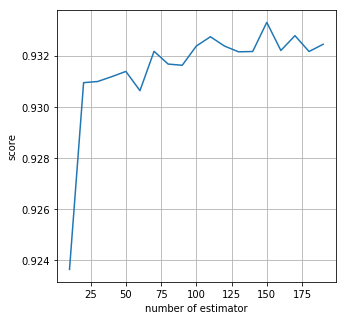

In [36]:
# Establish model
model = RandomForestRegressor(n_jobs=-1)
# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.figure(figsize=(5, 5))
plt.xlabel("number of estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
plt.grid()
results = list(zip(estimators))
results

In [196]:
scores

[0.9244565360535464,
 0.9294030857636403,
 0.9287816012707173,
 0.931277923328461,
 0.9313522326645143,
 0.9320113917365122,
 0.9316375953113984,
 0.9325276142030183,
 0.9318829089218916,
 0.9323530332032204,
 0.9328465517740923,
 0.9325311635453873,
 0.9326543660324013,
 0.9326989447371195,
 0.9330982402268998,
 0.9323485015910009,
 0.9329593116279158,
 0.9324702817294721,
 0.9331951323028106]